# **NYC TAXI**

In [ ]:
%pip install -r ../requirements.txt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np

In [ ]:
trainFull = pd.read_csv('../data/train.csv')
testFull = pd.read_csv('../data/test.csv')

##Checking for missing values

In [54]:
# Check for missing values in each column
missing_counts = trainFull.isnull().sum()

# Display columns that have missing values (if any)
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

if trainFull.isnull().values.any():
    print("\nThe dataset contains missing values.")
else:
    print("\nThe dataset has no missing values.")


Missing values per column:
Series([], dtype: int64)

The dataset has no missing values.


## Create features

In [33]:
def create_datetime_features(data):
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

    #Extract time features
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day'] = data['pickup_datetime'].dt.day
    data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek
    data['pickup_month'] = data['pickup_datetime'].dt.month
    
    #Pretty cool thing here cuz you map the time and day to a circle so the model understands
    #That 12AM (hour 0) and 11PM (23) are not far apart for example
    data['pickup_hour_sin'] = np.sin(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_hour_cos'] = np.cos(2 * np.pi * data['pickup_hour'] / 24)
    data['pickup_dayofweek_sin'] = np.sin(2 * np.pi * data['pickup_dayofweek'] / 7)
    data['pickup_dayofweek_cos'] = np.cos(2 * np.pi * data['pickup_dayofweek'] / 7)

    return data

def create_geo_features(data):
    #Calculate the shortest distance through 2 points
    def haversine_distance(lat1, lon1, lat2, lon2):
        radius = 6371  #Earth radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return radius * c

    #Very rough estimation of how you would actually drive to the point
    #since we can't drive through buildings
    def street_distance(lat1, lon1, lat2, lon2):
        lat_dist = haversine_distance(lat1, lon1, lat2, lon1)
        lon_dist = haversine_distance(lat1, lon1, lat1, lon2)
        return lat_dist + lon_dist
    
    data['haversine_distance'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    data['street_distance'] = street_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
    
    #Taxi speeds depend on how far they are from the city's "center"
    #I chose the East Village in Manhattan but thats an arbitrary choice
    nyc_center = (40.72680913695419, -73.98296948105471) #East Village 131 Ave A

    data['dropoff_distance_from_center'] = haversine_distance(data['dropoff_latitude'], data['dropoff_longitude'], nyc_center[0], nyc_center[1])
    data['pickup_distance_from_center'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'], nyc_center[0], nyc_center[1])

    return data

trainFull = create_datetime_features(trainFull)
trainFull = create_geo_features(trainFull)

In [47]:
# View original data structure
print("=== ORIGINAL DATA (trainFull) ===")
print(f"Shape: {trainFull.shape}")
print(f"\nColumns: {list(trainFull.columns)}")
print(f"\nFirst few rows:")
print(trainFull.head())
print(f"\nData types:")
print(trainFull.dtypes)

=== ORIGINAL DATA (trainFull) ===
Shape: (1458644, 26)

Columns: ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_hour', 'pickup_day', 'pickup_dayofweek', 'pickup_month', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_dayofweek_sin', 'pickup_dayofweek_cos', 'haversine_distance', 'street_distance', 'dropoff_distance_from_center', 'pickup_distance_from_center', 'pickup_date', 'dropoff_date', 'dropoff_month']

First few rows:
          id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passen

##Feature Visualizations 

Do days of the week dictate the average trip duration? What about quieter hours of the day? 
We include vendor id as an additional feature

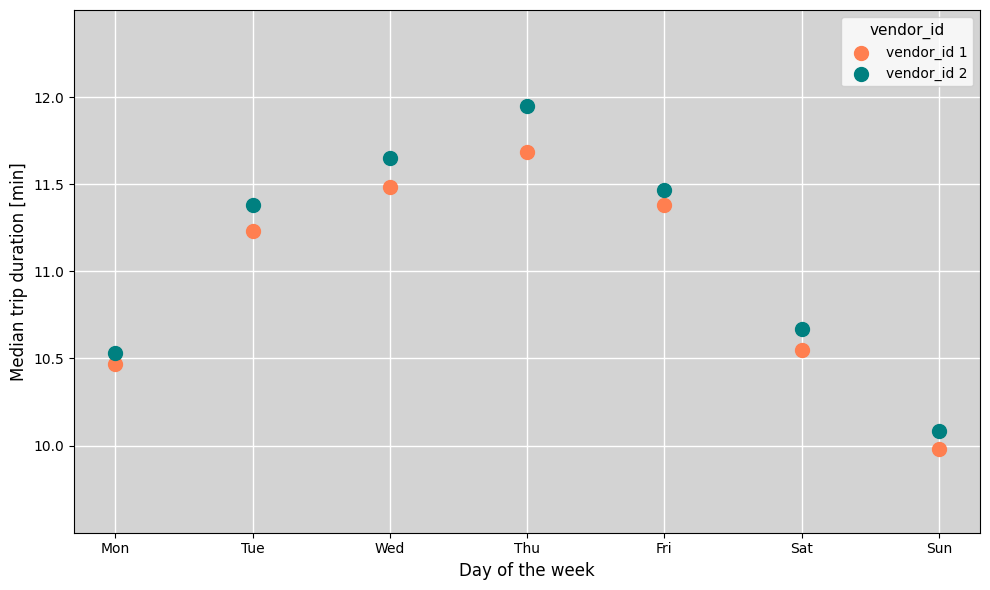

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert trip_duration from seconds to minutes
trainFull['trip_duration_min'] = trainFull['trip_duration'] / 60

# Map day of week numbers to day names
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
trainFull['day_name'] = trainFull['pickup_dayofweek'].map({i: day_names[i] for i in range(7)})

# Calculate median trip duration by day of week and vendor_id
median_duration = trainFull.groupby(['day_name', 'vendor_id'])['trip_duration_min'].median().reset_index()
median_duration = median_duration.sort_values(['day_name', 'vendor_id'])

# Ensure correct order of days
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
median_duration['day_name'] = pd.Categorical(median_duration['day_name'], categories=day_order, ordered=True)
median_duration = median_duration.sort_values('day_name')

# Create the visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data by vendor_id
vendor_1 = median_duration[median_duration['vendor_id'] == 1]
vendor_2 = median_duration[median_duration['vendor_id'] == 2]

# Plot scatter points
ax.scatter(vendor_1['day_name'], vendor_1['trip_duration_min'], 
           color='coral', s=100, label='vendor_id 1', zorder=3)
ax.scatter(vendor_2['day_name'], vendor_2['trip_duration_min'], 
           color='teal', s=100, label='vendor_id 2', zorder=3)

# Styling to match the image
ax.set_xlabel('Day of the week', fontsize=12)
ax.set_ylabel('Median trip duration [min]', fontsize=12)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white', linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(title='vendor_id', fontsize=10, title_fontsize=11)

# Set y-axis limits and ticks to match the style
ax.set_ylim(bottom=9.5, top=12.5)
ax.set_yticks([10.0, 10.5, 11.0, 11.5, 12.0])

plt.tight_layout()
plt.show()

#**Feature selection**

In [ ]:
#Select features for the model
feature_columns = [
    # Geographic features
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'haversine_distance', 'street_distance',
    'pickup_distance_from_center', 'dropoff_distance_from_center',
    
    # Time features
    'pickup_hour_sin', 'pickup_hour_cos',
    'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
    'pickup_day', 'pickup_month',
]

X = trainFull[feature_columns]
y = trainFull['trip_duration']

mask = ~np.isnan(y)
X_clean = X[mask]
Y_clean = y[mask]

## Hyperparameter tuning: Train models with different 

In [ ]:
#Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=39)

hyperparams = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300, 500],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_leaf': [1, 5, 10, 20],
    'l2_regularization': [0, 0.1, 1, 10],
    'max_leaf_nodes': [15, 31, 63, 127],
}

base_model = HistGradientBoostingRegressor(
    random_state=39,
    early_stopping=True,
    validation_fraction=0.2
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=hyperparams,
    n_iter=20,
    scoring='neg_mean_squared_error',
)

#fit the random search
print("Currently tuning hyperparameters. Sit tight...")
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score: {random_search.best_score_}")

#Get the best model
best_model = random_search.best_estimator_